# Enron Fraud Detection using Email and Financial Data

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives.

The goal of this project is to use  email (text) and financial data to construct a predictive model that could identify an individual as a person of interest (poi). The [Enron corpus](https://www.cs.cmu.edu/~./enron/) was made public by the US Federal Energy Regulatory Comission during its investgiation of Enron, which comprised email and financial data of 146 individuals mostly in senior management positions. The data has been widely used for various machine learning problems. However, there is value in the mentioned analysis for potential use to identify similar cases in other companies or for spam filtering application.

### First, all needed packages and functions are imported.

In [133]:
import sys
sys.path.append( "../tools/" )
sys.path.append( "../enron_mail_20110402/" )
sys.path.append( "../emails_by_address/" )
import math
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import string
import os
import pickle
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from poi_email_addresses import poiEmails
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from collections import defaultdict
import matplotlib.pyplot as plt

### Load the financial data

In [6]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

## Email Data

In [7]:
### Make a list of email addresses of persons of interest (poi)
poi_emails = poiEmails()
emails = []
for name in data_dict:
    if data_dict[name]['email_address']!='NaN':
        emails.append(data_dict[name]['email_address'])

In [8]:
### Make a list of all names of the individuals to remove from
### the email data (signature or mentions) to stop unrealistic performance.
names = []
for name in data_dict:
    name = re.sub('[^a-zA-Z \n\.]', ' ', name)
    name = name.replace('\n', ' ').replace('\r', '').replace('\t', ' ')
    name = re.sub(' +', ' ', name)
    name = name.strip()
    name = name.lower()
    name_components = name.split(" ")
    names.extend(name_components)

In [9]:
def stem_it(word):
    """ input a word and receive the stemmed word
        """
    stemmer = SnowballStemmer("english")
    stemmed_word = stemmer.stem(word)
    return stemmed_word

def parseOutText(f):
    """ given an opened email file f, parse out all text below the
        metadata block at the top, remove stopwords and add stemming.
        and return a list that contains all the words
        in the email.
        """
    f.seek(0)  ### go back to beginning of file.
    all_text = f.read()

    ### split off metadata
    content = all_text.split("X-FileName:")
    words = ""
    if len(content) > 1:
        ### remove punctuation
        text_string = content[1].translate(string.maketrans("", ""), string.punctuation)

        ### preprocessing
        text_string = re.sub('[^a-zA-Z \n\.]', ' ', text_string)
        text_string = text_string.replace('\n', ' ').replace('\r', '').replace('\t', ' ')
        text_string = re.sub(' +', ' ', text_string)
        text_string = text_string.lower()
        text_string = text_string.strip()
        words = text_string.split(" ")

        ### split the text string into individual words,remove stopwords stem each word,
        ### and append the stemmed word to words.
        sw = stopwords.words('english')
        filtered_words = [word for word in words if word not in sw]
        filtered_words = [word for word in filtered_words if word not in names]
        stemmed_words = [stem_it(word) for word in filtered_words]
        stemmed_words_pasted = " ".join(stemmed_words)

    return stemmed_words

In [ ]:
### Construct a list of stemmed words in emails sent from 
### each email address.

from_data = []
word_database = []

for email in emails:
    temp_counter = 0
    word_data = []
    from_email = 'emails_by_address/from_'+email+'.txt'
    # Do not take in financial data of an individual 
    # if email is not available.
    try:
        from_person = open(from_email, "r")
    except:
        continue
    for path in from_person:
        if temp_counter < 4:
            #temp_counter += 1
            path = os.path.join('..', path[:-1])
            email_txt = open(path, "r")
            txt = parseOutText(email_txt)
            word_data.extend(txt)
    email_txt.close()
    word_data_pasted = " ".join(word_data)
    word_database.append(word_data_pasted)
    from_data.append(email)
    from_person.close()
        

In [ ]:
### Save (Pickle) email data and sender data for fast load.
pickle.dump( word_database, open("word_database.pkl", "w") )
pickle.dump( from_data, open("from_data.pkl", "w") )

In [92]:
### Load the email data and sender data.
word_database = pickle.load(open("word_database.pkl", "r") )
from_data = pickle.load(open("from_data.pkl", "r") )

## Financial Data

In [93]:
### Select what features to start with

all_features =  ['salary', 'to_messages', 'deferral_payments', 'total_payments',
                 'exercised_stock_options', 'bonus', 'restricted_stock',
                 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value',
                 'expenses', 'loan_advances', 'from_messages', 'other',
                 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income',
                 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


In [94]:
### Extract the data from the dictionary and save it
### a panda dataframe
database_dict = defaultdict(list)
for name in data_dict:
    if (data_dict[name]['email_address']!='NaN') and (data_dict[name]['email_address'] in from_data):
        for feature in all_features:
            if data_dict[name][feature]=='NaN':
                database_dict[feature].append(None)
            else:
                database_dict[feature].append(data_dict[name][feature])
                
database_numerical = pd.DataFrame(database_dict)
database_numerical['poi'] = database_numerical['poi'].map({True:1, False:0})
database_numerical = database_numerical.fillna(0)

In [95]:
### Task 3: Create new feature(s)
database_numerical['all_messages'] = database_numerical['from_messages']+database_numerical['to_messages']
database_numerical['all_poi_messages'] = database_numerical['from_this_person_to_poi']+\
                                        database_numerical['from_poi_to_this_person']
database_numerical['poi_to_all_ratio'] = database_numerical['all_poi_messages']/database_numerical['all_messages']
database_numerical['total_payments_log'] = (database_numerical['total_payments']+1e-3).apply(math.log)
database_numerical['salary_log'] = (database_numerical['salary']+1e-3).apply(math.log)
database_numerical['bonus_log'] = (database_numerical['bonus']+1e-3).apply(math.log)
database_numerical['total_stock_value_log'] = (database_numerical['total_stock_value']+1e-3).apply(math.log)
database_numerical['exercised_stock_options_log'] = (database_numerical['exercised_stock_options']+1e-3).apply(math.log)
database_numerical['loan_advances_log'] = (database_numerical['loan_advances']+1e-3).apply(math.log)
database_numerical['director_fees_log'] = (database_numerical['director_fees']+1e-3).apply(math.log)
database_numerical['restricted_stock_log'] = abs(database_numerical['restricted_stock']+1e-3).apply(math.log)
database_numerical['deferral_payments_log'] = (database_numerical['deferral_payments']+1e-3).apply(math.log)
database_numerical['total_payments_sqrt'] = (database_numerical['total_payments']).apply(math.sqrt)
database_numerical['salary_sqrt'] = (database_numerical['salary']).apply(math.sqrt)
database_numerical['bonus_sqrt'] = (database_numerical['bonus']).apply(math.sqrt)
database_numerical['total_stock_value_sqrt'] = (database_numerical['total_stock_value']).apply(math.sqrt)
database_numerical['exercised_stock_options_sqrt'] = (database_numerical['exercised_stock_options']).apply(math.sqrt)
database_numerical['loan_advances_sqrt'] = (database_numerical['loan_advances']).apply(math.sqrt)
database_numerical['director_fees_sqrt'] = (database_numerical['director_fees']).apply(math.sqrt)
database_numerical['restricted_stock_sqrt'] = abs(database_numerical['restricted_stock']).apply(math.sqrt)
database_numerical['deferral_payments_sqrt'] = (database_numerical['deferral_payments']).apply(math.sqrt)
database_numerical['total_payments_squared'] = (database_numerical['total_payments']).apply(lambda x:x**2)
database_numerical['salary_squared'] = (database_numerical['salary']).apply(lambda x:x**2)
database_numerical['bonus_squared'] = (database_numerical['bonus']).apply(lambda x:x**2)
database_numerical['total_stock_value_squared'] = (database_numerical['total_stock_value']).apply(lambda x:x**2)
database_numerical['exercised_stock_options_squared'] = (database_numerical['exercised_stock_options']).apply(lambda x:x**2)
database_numerical['loan_advances_squared'] = (database_numerical['loan_advances']).apply(lambda x:x**2)
database_numerical['director_fees_squared'] = (database_numerical['director_fees']).apply(lambda x:x**2)
database_numerical['restricted_stock_squared'] = (database_numerical['restricted_stock']).apply(lambda x:x**2)
database_numerical['deferral_payments_sqrd'] = (database_numerical['deferral_payments']).apply(lambda x:x**2)

### Substitute 0 instead of NaN
database_numerical = database_numerical.fillna(0)

## Text analysis

In [96]:
### split the data into training and test datasets.
features_train, features_test,labels_train,\
labels_test = train_test_split(word_database, from_data, test_size=0.2, random_state=42)


### Use Tfidf to vectorize the email data
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.2,
                             stop_words='english')
features_train_tfidf = vectorizer.fit_transform(features_train)
features_test_tfidf  = vectorizer.transform(features_test)

In [97]:
### Perform encoding on the poi vaiable
### 0:non-poi and 1:poi

def label_encoder(labels):
    labels_enconded =[]
    for email in labels:
        if email in poi_emails: labels_enconded.append(1)
        else:labels_enconded.append(0)
    return labels_enconded
    
labels_enconded = label_encoder(from_data)
labels_train_enconded = label_encoder(labels_train)
labels_test_enconded = label_encoder(labels_test)

In [98]:
print sum(labels_enconded)
print sum(labels_test_enconded)
print len(labels_enconded)

14
4
86


#### There are 14 points in the data set, 14 in the training data set and 4 in the test dataset. 
#### Overal, 86 samples (poi and non-poi) are avaible with email data.

In [99]:
### Check if poi are avaialable with financial data but no email data
for name in data_dict:
    if data_dict[name]['poi']==True and\
    data_dict[name]['email_address'] not in from_data:
        print name
        print data_dict[name]['email_address']

KOPPER MICHAEL J
michael.kopper@enron.com
FASTOW ANDREW S
andrew.fastow@enron.com
YEAGER F SCOTT
scott.yeager@enron.com
HIRKO JOSEPH
joe.hirko@enron.com


### Feature selection

In [100]:
### Test classifier based on data needed for feature selection and evaluations later
def classifier_tester(clf, features, labels, folds = 1000):
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."
        
    return f1
    


In [101]:
### This function is the pipeline that performs feature selection
### The approach is a bit different from the normal approach and 
### using sklearn's pipeline was not possible
### RandomForestClassifier is used here after iterations with other algorithms.
### The same procedure will be repeated after feature selection with more comments.

def feature_selection_pipeline(features_train_tfidf,labels_train_enconded,\
                               percentile, n_components, max_depth, n_estimators):
    selector = SelectPercentile(f_classif, percentile=percentile)
    selector.fit(features_train_tfidf, labels_train_enconded)
    features_train_selected = selector.transform(features_train_tfidf)
    features_test_selected  = selector.transform(features_test_tfidf)
    pca = PCA(n_components=n_components)
    pca.fit(features_train_selected.toarray())
    features_train_selected = pca.transform(features_train_selected.toarray())
    features_test_selected = pca.transform(features_test_selected.toarray())
    data_base_train_tfidf = pd.DataFrame(features_train_selected)
    data_base_test_tfidf = pd.DataFrame(features_test_selected)
    data_base_train_tfidf['email_address'] = labels_train
    data_base_test_tfidf['email_address'] = labels_test
    database_numerical_train = database_numerical[database_numerical['email_address']\
                                                  .isin(data_base_train_tfidf['email_address'])]
    database_numerical_test = database_numerical[database_numerical['email_address']\
                                                 .isin(data_base_test_tfidf['email_address'])]
    data_base_train_tfidf = data_base_train_tfidf.set_index(['email_address'])
    data_base_test_tfidf = data_base_test_tfidf.set_index(['email_address'])
    database_numerical_train = database_numerical_train.set_index(['email_address'])
    database_numerical_test = database_numerical_test.set_index(['email_address'])
    database_train = database_numerical_train.join(data_base_train_tfidf)
    database_test = database_numerical_test.join(data_base_test_tfidf)
    train_labels = database_train['poi'].values
    test_labels = database_test['poi'].values
    database_train = database_train.drop('poi', axis=1).as_matrix()
    database_test = database_test.drop('poi', axis=1).as_matrix()
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(database_train)
    database_train = scaler.transform(database_train)
    database_test = scaler.transform(database_test)
    clf_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=max_depth, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=n_estimators, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
    f1 = classifier_tester(clf_rf, database_train, train_labels, folds = 200)

    return f1

In [181]:
### define searhc area
param_grid = dict(pca_n_components=[40, 50, 60, 68],
                  selector_percentile=[10],
                  rf_max_depth=[2, 3],
                  rf_n_estimators=[5, 10])
### Accept a dictionary of parameter and find the best combination
def GridSearcher(features_train_tfidf, labels_train_enconded, param_grid, base_f1=0):
    for n in param_grid['pca_n_components']:
        for p in param_grid['selector_percentile']:
            for depth in param_grid['rf_max_depth']:
                for estimator in param_grid['rf_n_estimators']:
                    current_f1 = feature_selection_pipeline(features_train_tfidf,labels_train_enconded,p, n, depth, estimator)
                    if current_f1 > base_f1:
                        base_f1 = current_f1
                        print "=======================new best", base_f1 , p, n, depth, estimator
                        best_param = dict(pca_n_components=n,
                                           selector_percentile=p,
                                           rf_max_depth=depth,
                                           rf_n_estimators=estimator)
    return best_param


best_combination = GridSearcher(features_train_tfidf, labels_train_enconded, param_grid, base_f1=0)
print best_combination

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
	Accuracy: 0.92000	Precision: 0.94898	Recall: 0.46500	F1: 0.62416	F2: 0.51782
	Total predictions: 1400	True positives:   93	False positives:    5	False negatives:  107	True negatives: 1195

=======================new best 0.624161073826 10 40 2 5
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False

In [182]:
### Plot effect of change of percentile on f1 score:
percentiles = [5, 10, 15, 20, 30, 40, 50, 80]
f1_scores=[]
for percentile in percentiles:
    current_f1 = feature_selection_pipeline(features_train_tfidf,labels_train_enconded,percentile, 68, 2, 5)
    f1_scores.append(current_f1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
	Accuracy: 0.98143	Precision: 1.00000	Recall: 0.87000	F1: 0.93048	F2: 0.89322
	Total predictions: 1400	True positives:  174	False positives:    0	False negatives:   26	True negatives: 1200

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
	Accuracy: 0.98643	Precision: 0.96891	Recall: 0.93500	F1

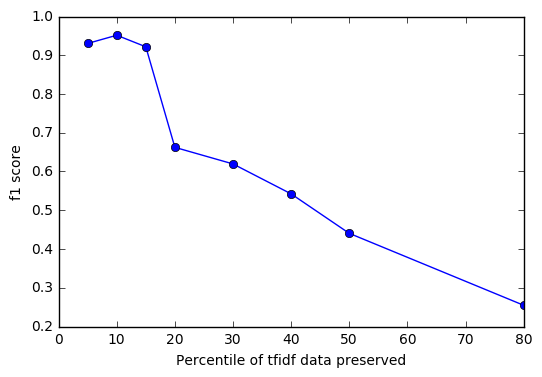

In [183]:
%matplotlib inline
ax = plt.plot(percentiles, f1_scores, '-bo')
plt.xlabel('Percentile of tfidf data preserved')
plt.ylabel('f1 score')
pickle.dump([percentiles, f1_scores] , file('f1plot.pickle', 'w'))
plt.show()


In [186]:
### Perform feature selection on the tfidf dataset and 
### keep the most-important 10% of the data based on the pipeline.
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(features_train_tfidf, labels_train_enconded)
features_train_selected = selector.transform(features_train_tfidf)
features_test_selected  = selector.transform(features_test_tfidf)

In [153]:
### Perform PCA on the training data and transform both datasets
### 68 was chosen due to the result of the pipeline
pca = PCA(n_components=68)
pca.fit(features_train_selected.toarray())
features_train_selected = pca.transform(features_train_selected.toarray())
features_test_selected = pca.transform(features_test_selected.toarray())

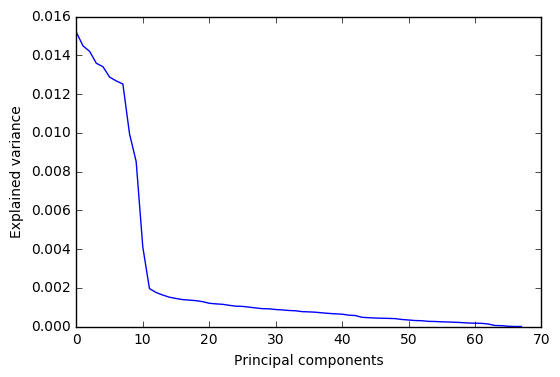

   Explained_variance
0            0.015181
1            0.014482
2            0.014199
3            0.013586
4            0.013410
5            0.012872
6            0.012675
7            0.012514
8            0.009947
9            0.008514


In [198]:
pickle.dump(pca , file('pca.pickle', 'w'))
plt.plot(pca.explained_variance_)
plt.xlabel('Principal components')
plt.ylabel('Explained variance')
plt.show()
e_v = pd.DataFrame(pca.explained_variance_, columns=['Explained_variance'])
pickle.dump(e_v , file('pca.pickle', 'w'))

In [154]:
### Save the dataset(dict) as panda dataframes
data_base_train_tfidf = pd.DataFrame(features_train_selected)
data_base_test_tfidf = pd.DataFrame(features_test_selected)
data_base_train_tfidf['email_address'] = labels_train
data_base_test_tfidf['email_address'] = labels_test

## Combining email and financial datasets

In [155]:
### Split the financial data into training and test based on email addresses 
### available in the email data training and test
database_numerical_train = database_numerical[database_numerical['email_address'].isin(data_base_train_tfidf['email_address'])]
database_numerical_test = database_numerical[database_numerical['email_address'].isin(data_base_test_tfidf['email_address'])]

In [156]:
### Set email address as unique identifier (index) for training and test 
### datasets of both email and financial dataframes.
data_base_train_tfidf = data_base_train_tfidf.set_index(['email_address'])
data_base_test_tfidf = data_base_test_tfidf.set_index(['email_address'])
database_numerical_train = database_numerical_train.set_index(['email_address'])
database_numerical_test = database_numerical_test.set_index(['email_address'])

In [157]:
## Join the training dataset of email (tfidf) and financial dataframes.
## Join the test dataset of email (tfidf) and financial dataframes.
database_train = database_numerical_train.join(data_base_train_tfidf)
database_test = database_numerical_test.join(data_base_test_tfidf)

### Construct a master dataset to write out the data from.
whole_database = pd.concat([database_train,database_test])

In [158]:
### Make the final feature list based on the columns in the master dataframe
### and put poi as the first feature.
features_list = list(whole_database.columns)
features_list.remove('poi')
features_list.insert(0,'poi')

In [159]:
### Construct a dictionary dataset from the master dataframe.
keys = whole_database.index.values
my_dataset={}
for key in keys:
    my_dataset[key]={}
    for feature in features_list:
        my_dataset[key][feature]=whole_database.loc[key, feature]
        
### Moving to our original training and test dataframes for the rest
### of the analysis.
keys_train = database_train.index.values
my_train_dataset={}
for key in keys_train:
    my_train_dataset[key]={}
    for feature in features_list:
        my_train_dataset[key][feature]=database_train.loc[key, feature]

In [160]:
### preparing labels and features for sklearn
train_labels = database_train['poi'].values
test_labels = database_test['poi'].values
database_train = database_train.drop('poi', axis=1).as_matrix()
database_test = database_test.drop('poi', axis=1).as_matrix()

In [161]:
### Scaling the features.
scaler = preprocessing.MinMaxScaler()
scaler.fit(database_train)
database_train = scaler.transform(database_train)
database_test = scaler.transform(database_test)

###  Machine learning

In [162]:
### Script to test the classifiers
import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

#def main():
#    ### load up student's classifier, dataset, and feature_list
#    clf, dataset, feature_list = load_classifier_and_data()
#    ### Run testing script
#    test_classifier(clf, dataset, feature_list)

#if __name__ == '__main__':
#    main()


In [163]:
### Naive bayes
clf_nb = GaussianNB()
test_classifier(clf_nb, my_train_dataset, feature_list)
clf_nb.fit(database_train, train_labels)
#scoretr_nb = clf_nb.score(database_train, train_labels)
#print "Training accuracy: ", scoretr_nb
scorete_nb = clf_nb.score(database_test, test_labels)
print "Test accuracy: ", scorete_nb
pred_nb = clf_nb.predict(database_test)
print "Confusion matrix: \n", confusion_matrix(test_labels, pred_nb)
print "Recall score is: ", recall_score(test_labels, pred_nb)
print "Precision score is: ",precision_score(test_labels, pred_nb)
print "F1 score is: ",f1_score(test_labels, pred_nb)

Got a divide by zero when trying out: GaussianNB(priors=None)
Precision or recall may be undefined due to a lack of true positive predicitons.
Test accuracy:  0.222222222222
Confusion matrix: 
[[ 0 14]
 [ 0  4]]
Recall score is:  1.0
Precision score is:  0.222222222222
F1 score is:  0.363636363636


In [164]:
### Grid search support vectore machines
parameters ={'kernel':('linear', 'rbf', 'sigmoid', 'poly'),
             'C':[1e-22, 1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1, 2],
             'degree':[2, 3, 4, 5],
             'gamma':[0.0001, 0.01, 0.05, 0.1, 0.2, 1, 2]}
svm = SVC(random_state=7)
clf_svm = GridSearchCV(svm, parameters)
clf_svm.fit(database_train, train_labels)
scoretr_svm = clf_svm.score(database_train, train_labels)
print "Training accuracy: ", scoretr_svm
scorete_svm = clf_svm.score(database_test, test_labels)
print "Test accuracy: ", scorete_svm
pred_svm = clf_svm.predict(database_test)
print "Confusion matrix: \n", confusion_matrix(test_labels, pred_svm)
print "Recall score is: ", recall_score(test_labels, pred_svm)
print "Precision score is: ",precision_score(test_labels, pred_svm)
print "F1 score is: ",f1_score(test_labels, pred_svm)
print clf_svm.best_estimator_

Training accuracy:  1.0
Test accuracy:  0.722222222222
Confusion matrix: 
[[10  4]
 [ 1  3]]
Recall score is:  0.75
Precision score is:  0.428571428571
F1 score is:  0.545454545455
SVC(C=1e-06, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=5, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=7, shrinking=True,
  tol=0.001, verbose=False)


In [165]:
### Support vectore machines
clf_svm = SVC(C=1e-06, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=5, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=7, shrinking=True,
  tol=0.001, verbose=False)

test_classifier(clf_svm, my_train_dataset, feature_list)
clf_svm.fit(database_train, train_labels)
#scoretr_svm = clf_svm.score(database_train, train_labels)
#print "Training accuracy: ", scoretr_svm
scorete_svm = clf_svm.score(database_test, test_labels)
print "Test accuracy: ", scorete_svm
pred_svm = clf_svm.predict(database_test)
print "Confusion matrix: \n", confusion_matrix(test_labels, pred_svm)
print "Recall score is: ", recall_score(test_labels, pred_svm)
print "Precision score is: ",precision_score(test_labels, pred_svm)
print "F1 score is: ",f1_score(test_labels, pred_svm)

SVC(C=1e-06, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=5, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=7, shrinking=True,
  tol=0.001, verbose=False)
	Accuracy: 0.14286	Precision: 0.14286	Recall: 1.00000	F1: 0.25000	F2: 0.45455
	Total predictions: 7000	True positives: 1000	False positives: 6000	False negatives:    0	True negatives:    0

Test accuracy:  0.722222222222
Confusion matrix: 
[[10  4]
 [ 1  3]]
Recall score is:  0.75
Precision score is:  0.428571428571
F1 score is:  0.545454545455


In [166]:
### Linear classifiers 
parameters ={'loss':('log', 'hinge'), 'penalty':('l2', 'l1', 'elasticnet'),\
             'alpha':[1e-8, 1e-4, 1e-2, 1e-1, 1, 10, 100, 100000]}
sgd = SGDClassifier(random_state=1)
clf_sgd = GridSearchCV(sgd, parameters)
clf_sgd.fit(database_train, train_labels)
scoretr_sgd = clf_sgd.score(database_train, train_labels)
print "Training accuracy: ",scoretr_sgd
scorete_sgd = clf_sgd.score(database_test, test_labels)
print "Test accuracy: ", scorete_sgd
pred_sgd = clf_sgd.predict(database_test)
print "Confusion matrix: \n", confusion_matrix(test_labels, pred_sgd)
print "Recall score is: ", recall_score(test_labels, pred_sgd)
print "Precision score is: ",precision_score(test_labels, pred_sgd)
print "F1 score is: ",f1_score(test_labels, pred_sgd)
print clf_sgd.best_estimator_

Training accuracy:  0.985294117647
Test accuracy:  0.833333333333
Confusion matrix: 
[[13  1]
 [ 2  2]]
Recall score is:  0.5
Precision score is:  0.666666666667
F1 score is:  0.571428571429
SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=1, shuffle=True, verbose=0,
       warm_start=False)


In [167]:
### SGD
clf_sgd = SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=1, shuffle=True, verbose=0,
       warm_start=False)
test_classifier(clf_sgd, my_train_dataset, feature_list)
clf_sgd.fit(database_train, train_labels)
#scoretr_sgd = clf_sgd.score(database_train, train_labels)
#print "Training accuracy: ",scoretr_sgd
scorete_sgd = clf_sgd.score(database_test, test_labels)
print "Test accuracy: ", scorete_sgd
pred_sgd = clf_sgd.predict(database_test)
print "Confusion matrix: \n", confusion_matrix(test_labels, pred_sgd)
print "Recall score is: ", recall_score(test_labels, pred_sgd)
print "Precision score is: ",precision_score(test_labels, pred_sgd)
print "F1 score is: ",f1_score(test_labels, pred_sgd)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=1, shuffle=True, verbose=0,
       warm_start=False)
	Accuracy: 0.21957	Precision: 0.14267	Recall: 0.89100	F1: 0.24596	F2: 0.43485
	Total predictions: 7000	True positives:  891	False positives: 5354	False negatives:  109	True negatives:  646

Test accuracy:  0.833333333333
Confusion matrix: 
[[13  1]
 [ 2  2]]
Recall score is:  0.5
Precision score is:  0.666666666667
F1 score is:  0.571428571429


In [168]:
### Linear regression
parameters ={'C':[1e-22, 1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1, 2, 4, 6]}
lr = LogisticRegression()
clf_lr = GridSearchCV(lr, parameters)
clf_lr.fit(database_train, train_labels)
scoretr_lr = clf_lr.score(database_train, train_labels)
print "Training accuracy: ",scoretr_lr
scorete_lr = clf_lr.score(database_test, test_labels)
print "Test accuracy: ", scorete_lr
pred_lr = clf_lr.predict(database_test)
print "Confusion matrix: \n", confusion_matrix(test_labels, pred_lr)
print "Recall score is: ", recall_score(test_labels, pred_lr)
print "Precision score is: ",precision_score(test_labels, pred_lr)
print "F1 score is: ",f1_score(test_labels, pred_lr)
print clf_lr.best_estimator_

Training accuracy:  1.0
Test accuracy:  0.777777777778
Confusion matrix: 
[[13  1]
 [ 3  1]]
Recall score is:  0.25
Precision score is:  0.5
F1 score is:  0.333333333333
LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [169]:
### Linear regression
clf_lr = LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
test_classifier(clf_lr, my_train_dataset, feature_list)
clf_lr.fit(database_train, train_labels)
#scoretr_lr = clf_lr.score(database_train, train_labels)
#print "Training accuracy: ",scoretr_lr
scorete_lr = clf_lr.score(database_test, test_labels)
print "Test accuracy: ", scorete_lr
pred_lr = clf_lr.predict(database_test)
print "Confusion matrix: \n", confusion_matrix(test_labels, pred_lr)
print "Recall score is: ", recall_score(test_labels, pred_lr)
print "Precision score is: ",precision_score(test_labels, pred_lr)
print "F1 score is: ",f1_score(test_labels, pred_lr)

Got a divide by zero when trying out: LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Precision or recall may be undefined due to a lack of true positive predicitons.
Test accuracy:  0.777777777778
Confusion matrix: 
[[13  1]
 [ 3  1]]
Recall score is:  0.25
Precision score is:  0.5
F1 score is:  0.333333333333


In [170]:
### Grid search to ada boost
parameters ={'learning_rate':[0.001, 0.01, 0.1, 0.2, 0.5, 1 , 2], 'n_estimators':[5, 10, 20, 50]}
ada = AdaBoostClassifier(random_state=42)
clf_ada = GridSearchCV(ada, parameters)
clf_ada.fit(database_train, train_labels)
#scoretr_rf = clf_ada.score(database_train, train_labels)
#print "Training accuracy: ",scoretr_ada
scorete_ada = clf_ada.score(database_test, test_labels)
print "Test accuracy: ", scorete_ada
pred_ada = clf_ada.predict(database_test)
print "Confusion matrix: \n", confusion_matrix(test_labels, pred_ada)
print "Recall score is: ", recall_score(test_labels, pred_ada)
print "Precision score is: ",precision_score(test_labels, pred_ada)
print "F1 score is: ",f1_score(test_labels, pred_ada)
print clf_ada.best_estimator_

Test accuracy:  0.722222222222
Confusion matrix: 
[[10  4]
 [ 1  3]]
Recall score is:  0.75
Precision score is:  0.428571428571
F1 score is:  0.545454545455
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.01, n_estimators=20, random_state=42)


In [171]:
### Ada boost
clf_ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.01, n_estimators=20, random_state=42)
test_classifier(clf_ada, my_train_dataset, feature_list)
clf_ada.fit(database_train, train_labels)
#scoretr_ada = clf_ada.score(database_train, train_labels)
#print "Training accuracy: ",scoretr_ada
scorete_ada = clf_ada.score(database_test, test_labels)
print "Test accuracy: ", scorete_ada
pred_ada = clf_ada.predict(database_test)
print "Confusion matrix: \n", confusion_matrix(test_labels, pred_ada)
print "Recall score is: ", recall_score(test_labels, pred_ada)
print "Precision score is: ",precision_score(test_labels, pred_ada)
print "F1 score is: ",f1_score(test_labels, pred_ada)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.01, n_estimators=20, random_state=42)
	Accuracy: 0.95757	Precision: 0.82456	Recall: 0.89300	F1: 0.85742	F2: 0.87842
	Total predictions: 7000	True positives:  893	False positives:  190	False negatives:  107	True negatives: 5810

Test accuracy:  0.722222222222
Confusion matrix: 
[[10  4]
 [ 1  3]]
Recall score is:  0.75
Precision score is:  0.428571428571
F1 score is:  0.545454545455


In [172]:
clf_ada.feature_importances_

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.1 ,  0.  ,  0.25,  0.  ,  0.4 ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.25])

In [173]:
### Decision tree
parameters ={'min_samples_split':[2, 3, 4, 6]}
dt = DecisionTreeClassifier(random_state=1)
clf_dt = GridSearchCV(dt, parameters)
clf_dt.fit(database_train, train_labels)
scoretr_dt = clf_dt.score(database_train, train_labels)
print "Training accuracy: ",scoretr_dt
scorete_dt = clf_dt.score(database_test, test_labels)
print "Test accuracy: ",scorete_dt
pred_dt = clf_dt.predict(database_test)
print "Confusion matrix: \n",confusion_matrix(test_labels, pred_dt)
print "Recall score is: ", recall_score(test_labels, pred_dt)
print "Precision score is: ",precision_score(test_labels, pred_dt)
print "F1 score is: ",f1_score(test_labels, pred_dt)
print clf_dt.best_estimator_

Training accuracy:  1.0
Test accuracy:  0.777777777778
Confusion matrix: 
[[14  0]
 [ 4  0]]
Recall score is:  0.0
Precision score is:  0.0
F1 score is:  0.0
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')


In [174]:
### Decision tree
clf_dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')
test_classifier(clf_dt, my_train_dataset, feature_list)
clf_dt.fit(database_train, train_labels)
#scoretr_dt = clf_dt.score(database_train, train_labels)
#print "Training accuracy: ",scoretr_dt
scorete_dt = clf_dt.score(database_test, test_labels)
print "Test accuracy: ",scorete_dt
pred_dt = clf_dt.predict(database_test)
print "Confusion matrix: \n",confusion_matrix(test_labels, pred_dt)
print "Recall score is: ", recall_score(test_labels, pred_dt)
print "Precision score is: ",precision_score(test_labels, pred_dt)
print "F1 score is: ",f1_score(test_labels, pred_dt)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')
	Accuracy: 0.94371	Precision: 0.80422	Recall: 0.80100	F1: 0.80261	F2: 0.80164
	Total predictions: 7000	True positives:  801	False positives:  195	False negatives:  199	True negatives: 5805

Test accuracy:  0.777777777778
Confusion matrix: 
[[14  0]
 [ 4  0]]
Recall score is:  0.0
Precision score is:  0.0
F1 score is:  0.0


In [175]:
clf_dt.feature_importances_

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.11525424,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.88474576,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [176]:
### Grid search to optimize random forest
parameters ={'max_depth':[2, 4, 6, 8, 10], 'n_estimators':[5, 10, 20, 50]}
rf = RandomForestClassifier(random_state=42)
clf_rf = GridSearchCV(rf, parameters)
clf_rf.fit(database_train, train_labels)
#scoretr_rf = clf_rf.score(database_train, train_labels)
#print "Training accuracy: ",scoretr_rf
scorete_rf = clf_rf.score(database_test, test_labels)
print "Test accuracy: ", scorete_rf
pred_rf = clf_rf.predict(database_test)
print "Confusion matrix: \n", confusion_matrix(test_labels, pred_rf)
print "Recall score is: ", recall_score(test_labels, pred_rf)
print "Precision score is: ",precision_score(test_labels, pred_rf)
print "F1 score is: ",f1_score(test_labels, pred_rf)
print clf_rf.best_estimator_

Test accuracy:  0.722222222222
Confusion matrix: 
[[13  1]
 [ 4  0]]
Recall score is:  0.0
Precision score is:  0.0
F1 score is:  0.0
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)


In [177]:
### Random forest
clf_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
test_classifier(clf_rf, my_train_dataset, feature_list)
clf_rf.fit(database_train, train_labels)
#scoretr_rf = clf_rf.score(database_train, train_labels)
#print "Training accuracy: ", scoretr_rf
scorete_rf = clf_rf.score(database_test, test_labels)
print "Test accuracy: ", scorete_rf
pred_rf = clf_rf.predict(database_test)
print "Confusion matrix: \n", confusion_matrix(test_labels, pred_rf)
print "Recall score is: ", recall_score(test_labels, pred_rf)
print "Precision score is: ",precision_score(test_labels, pred_rf)
print "F1 score is: ",f1_score(test_labels, pred_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
	Accuracy: 0.96429	Precision: 0.96758	Recall: 0.77600	F1: 0.86127	F2: 0.80800
	Total predictions: 7000	True positives:  776	False positives:   26	False negatives:  224	True negatives: 5974

Test accuracy:  0.722222222222
Confusion matrix: 
[[13  1]
 [ 4  0]]
Recall score is:  0.0
Precision score is:  0.0
F1 score is:  0.0


In [178]:
clf_rf.feature_importances_

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.138322  ,  0.04533333,
        0.        ,  0.05762712,  0.20405089,  0.35466667,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

### Model selection
Due to a relatively high F1 score and faster training and prediction time. The grid search decision tree was selected as the final model.

In [179]:
clf = clf_rf

### Assesment
Assesment of the model using the benchmark code.

In [180]:
dump_classifier_and_data(clf, my_dataset, features_list)
clf, dataset, feature_list = load_classifier_and_data()
### Run testing script
test_classifier(clf, dataset, feature_list)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)
	Accuracy: 0.94011	Precision: 0.89673	Recall: 0.52100	F1: 0.65908	F2: 0.56865
	Total predictions: 9000	True positives:  521	False positives:   60	False negatives:  479	True negatives: 7940



### Disclaimer
Some of the original features in the original dataset like 'email from poi to this person' or 'shared receipts with poi' are not constructed correctly since we are building a predictive model and there is no way to know if someone is a poi or not before investigation. Thankfully, my model did not use any of the financial data in the final random forest attempt as evident from the feature importance list.
In addition, the benchmark code that measures accuracy of the model uses the both training and test data in the assesment, which is not the best practice.
